# Latency Analysis (excluding ECS CPU Utilization)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

## Load and Clean Data

In [3]:
file_paths = {
    "ec2_5": "results_with_cpu_ec2_5.csv",
    "ec2_10": "results_with_cpu_ec2_10.csv",
    "ec2_20": "results_with_cpu_ec2_20.csv",
    "ec2_50": "results_with_cpu_ec2_50.csv",
    "ecs_5": "results_with_cpu_ecs_5.csv",
    "ecs_10": "results_with_cpu_ecs_10.csv",
    "ecs_20": "results_with_cpu_ecs_20.csv",
    "ecs_50": "results_with_cpu_ecs_50.csv"
}

# Load and tag each file
dfs = []
for key, path in file_paths.items():
    deployment, users = key.split("_")
    df = pd.read_csv(path)
    df["deployment"] = deployment
    df["users"] = int(users)
    dfs.append(df)

# Combine all into one DataFrame
df = pd.concat(dfs, ignore_index=True)
df = df[df["success"] == True]
df["cpu_cores"] = 0.25  # Each task or container is assigned 0.25 vCPU
df["available_memory"] = 512  # Memory in MiB

# Encoding the endpoint as a numerical value
df["endpoint_code"] = df["endpoint"].map({
    "genai/chatclient": 1,
    "customer/owners": 2,
    "vet/vets": 3
})

# Encodeing the deployment setup as a numerical value
df["deployment_code"] = df["deployment"].map({
    "ecs": 1,
    "ec2": 2
})


In [4]:
df.to_excel("petclinic-data.xlsx", index=False)
df.head(100)

,timestamp,customer_id,endpoint,status_code,success,deployment,users,latency,api_cpu_utilization,api_mem_utilization,service_cpu_utilization,service_mem_utilization,cpu_cores,available_memory,endpoint_code,deployment_code
1,2025-04-03T03:40:02.919267,0,customer/owners,201,True,ec2,5,0.060093,0.80,83.56,0.96,67.64,0.25,512,2,2
2,2025-04-03T03:40:15.455528,0,vet/vets,200,True,ec2,5,0.071105,0.64,83.56,0.96,65.03,0.25,512,3,2
3,2025-04-03T03:39:46.530726,1,genai/chatclient,200,True,ec2,5,3.537114,0.56,83.56,5.60,79.22,0.25,512,1,2
4,2025-04-03T03:39:58.804708,1,customer/owners,201,True,ec2,5,0.058286,0.48,83.56,0.80,67.64,0.25,512,2,2
5,2025-04-03T03:40:11.180722,1,vet/vets,200,True,ec2,5,0.092147,0.88,83.56,0.72,65.03,0.25,512,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2025-04-03T03:41:35.831838,17,genai/chatclient,200,True,ec2,20,8.783659,25.52,83.60,0.88,79.22,0.25,512,1,2
97,2025-04-03T03:41:50.822460,17,customer/owners,201,True,ec2,20,0.094143,6.16,83.62,0.72,67.70,0.25,512,2,2
98,2025-04-03T03:42:03.331087,17,vet/vets,200,True,ec2,20,0.063221,3.36,83.62,0.80,65.03,0.25,512,3,2
99,2025-04-03T03:41:39.095811,18,genai/chatclient,200,True,ec2,20,9.512860,2.56,83.60,0.72,79.22,0.25,512,1,2


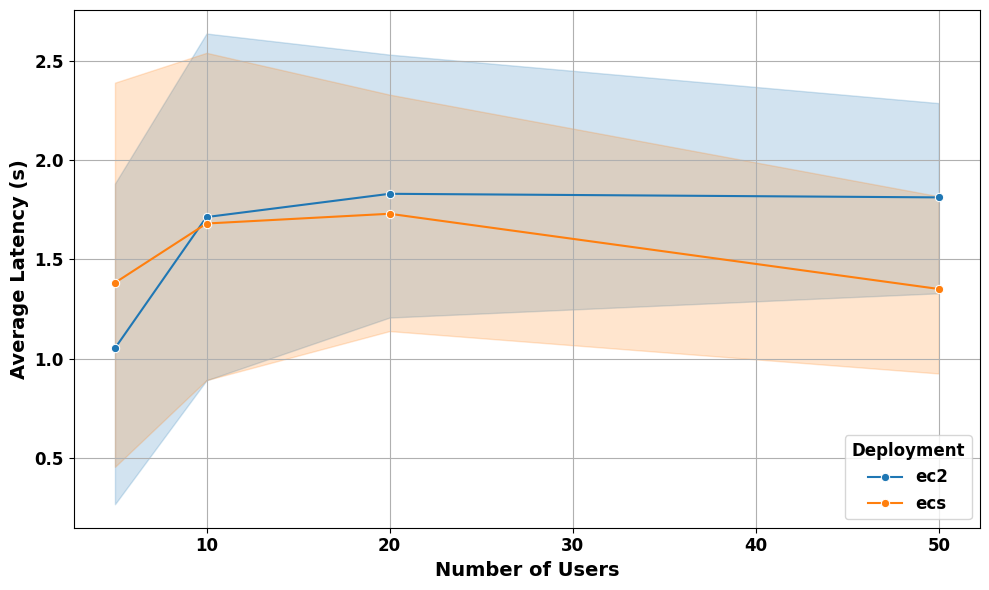

In [5]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="users", y="latency", hue="deployment", estimator='mean', marker="o")
# plt.title("Latency vs. Number of Users")
# Axis labels
plt.xlabel("Number of Users", fontsize=14, fontweight='bold')
plt.ylabel("Average Latency (s)", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
legend = plt.legend(title='Deployment', title_fontsize=12, fontsize=12)
legend.get_title().set_fontweight('bold')  # Bold legend title
for text in legend.get_texts():
    text.set_fontweight('bold')  # Bold legend labels


plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Show the overall average latency per user journey (chat -> owners -> vets) for each deployment and number of users
pivot_multi = df.groupby(["users", "deployment"]).agg({
    "api_cpu_utilization": "mean",
    "api_mem_utilization": "mean",
    "latency": "mean"
}).reset_index()
print(pivot_multi)

   users deployment  api_cpu_utilization  api_mem_utilization   latency
0      5        ec2             0.651429            83.560000  1.051982
1      5        ecs             0.630000            68.160000  1.381519
2     10        ec2            10.584000            83.574000  1.712195
3     10        ecs             0.630000            68.160000  1.679743
4     20        ec2            12.564211            83.607586  1.829301
5     20        ecs             0.607500            68.160000  1.728833
6     50        ec2            37.868364            83.650965  1.811213
7     50        ecs             0.600000            68.160000  1.350157


In [ ]:
# Show the average latency for each deployment and number of users per endpiont (service)
latency_by_group = (
    df.groupby(["users", "deployment", "endpoint"])
    .agg(avg_latency=("latency", "mean"))
    .reset_index()
)

print(latency_by_group)

    users deployment          endpoint  avg_latency
0       5        ec2   customer/owners     0.066587
1       5        ec2  genai/chatclient     3.500262
2       5        ec2          vet/vets     0.078752
3       5        ecs   customer/owners     0.074643
4       5        ecs  genai/chatclient     4.003794
5       5        ecs          vet/vets     0.066120
6      10        ec2   customer/owners     0.072812
7      10        ec2  genai/chatclient     4.980357
8      10        ec2          vet/vets     0.083416
9      10        ecs   customer/owners     0.075729
10     10        ecs  genai/chatclient     4.879761
11     10        ecs          vet/vets     0.083739
12     20        ec2   customer/owners     0.079719
13     20        ec2  genai/chatclient     5.325083
14     20        ec2          vet/vets     0.083101
15     20        ecs   customer/owners     0.072600
16     20        ecs  genai/chatclient     5.037218
17     20        ecs          vet/vets     0.076681
18     50   

In [ ]:
# Ignore the user group and show the overal latency experienced by each deployment (EC2 and ECS) for each endpoint (service)
grouped_latency = df.groupby(["endpoint", "deployment"])["latency"].mean().reset_index()

# showing EC2 and ECS side-by-side
pivot_latency = grouped_latency.pivot(index="endpoint", columns="deployment", values="latency")
pivot_latency.columns = ["EC2 Avg Latency (s)", "ECS Avg Latency (s)"]
print(pivot_latency.round(4))

                  EC2 Avg Latency (s)  ECS Avg Latency (s)
endpoint                                                  
customer/owners                0.0822               0.0733
genai/chatclient               5.5446               5.3213
vet/vets                       0.0988               0.0729


## Latency Distributions

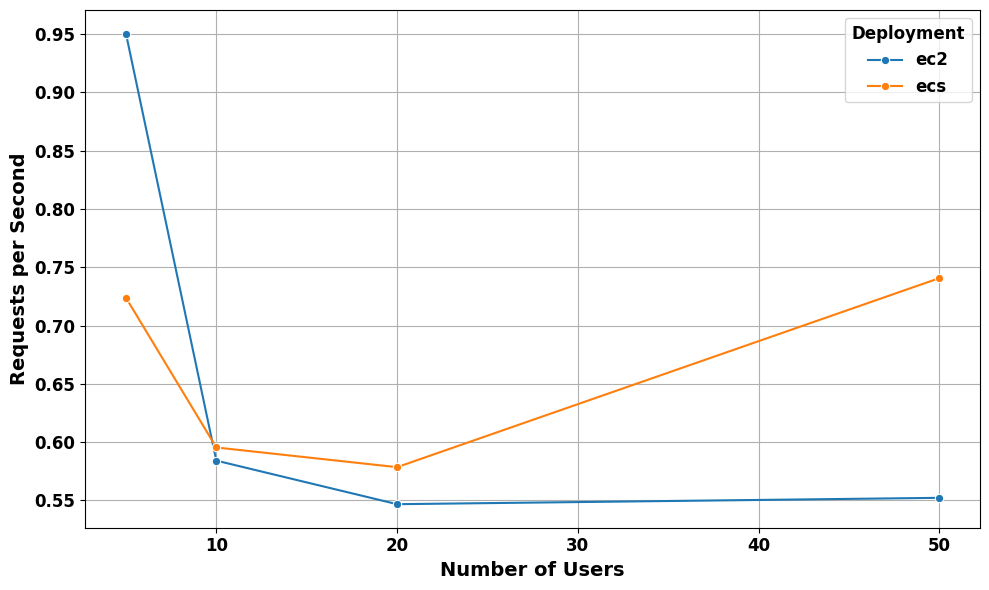

In [23]:
throughput_data = df.groupby(["users", "deployment"]).agg(
    total_requests=('latency', 'count'),
    avg_latency=('latency', 'mean')
).reset_index()

# Estimate test duration as average latency * number of requests
throughput_data["throughput_rps"] = throughput_data["total_requests"] / (throughput_data["avg_latency"] * throughput_data["total_requests"])

plt.figure(figsize=(10, 6))
sns.lineplot(data=throughput_data, x="users", y="throughput_rps", hue="deployment", marker="o")

plt.xlabel("Number of Users", fontsize=14, fontweight='bold')
plt.ylabel("Requests per Second", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
legend = plt.legend(title='Deployment', title_fontsize=12, fontsize=12)
legend.get_title().set_fontweight('bold')  # Bold legend title
for text in legend.get_texts():
    text.set_fontweight('bold')  # Bold legend labels


plt.grid(True)
plt.tight_layout()
plt.show()

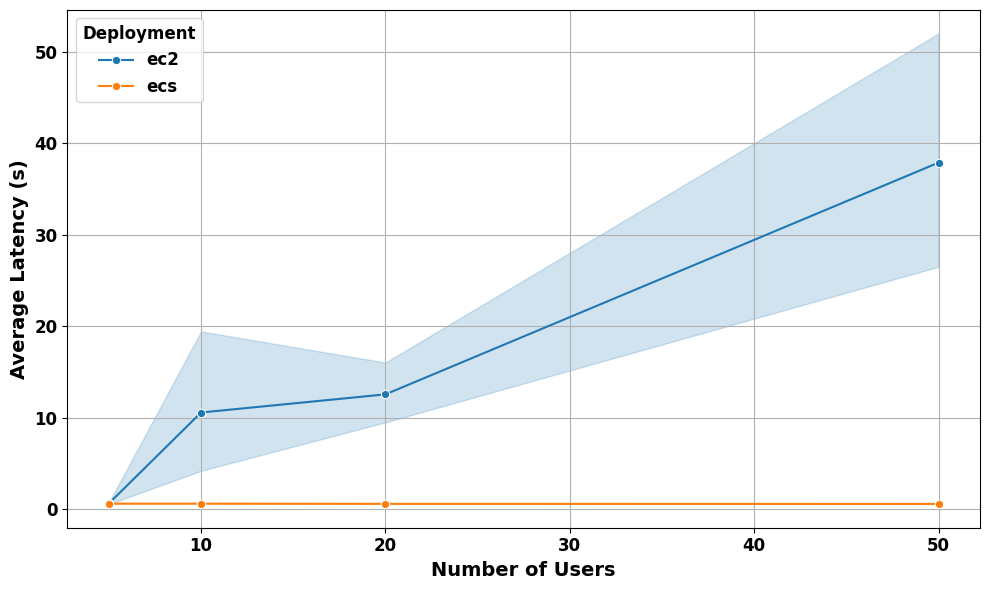

In [24]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="users", y="api_cpu_utilization", hue="deployment", estimator='mean', marker="o")
# plt.title("Latency vs. Number of Users")
# Axis labels
plt.xlabel("Number of Users", fontsize=14, fontweight='bold')
plt.ylabel("Average Latency (s)", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
legend = plt.legend(title='Deployment', title_fontsize=12, fontsize=12)
legend.get_title().set_fontweight('bold')  # Bold legend title
for text in legend.get_texts():
    text.set_fontweight('bold')  # Bold legend labels


plt.grid(True)
plt.tight_layout()
plt.show()


## Feature Selection

In [20]:

# features = [col for col in df.columns if col in ['endpoint', 'deployment', 'api_cpu_utilization', 'api_mem_utilization', 'service_cpu_utilization', 'service_mem_utilization', 'users'] or col.startswith("endpoint_") or col.startswith("deployment_")]
numerical_features = ['users', 'cpu_cores', 'available_memory', 'endpoint_code', 'deployment_code']
# categorical_features = ['endpoint', 'deployment']
X = df[numerical_features]
y = df["latency"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df.head(200)


,timestamp,customer_id,endpoint,status_code,success,deployment,users,latency,api_cpu_utilization,api_mem_utilization,service_cpu_utilization,service_mem_utilization,cpu_cores,available_memory,endpoint_code,deployment_code
1,2025-04-03T03:40:02.919267,0,customer/owners,201,True,ec2,5,0.060093,0.80,83.56,0.96,67.64,0.25,512,2,2
2,2025-04-03T03:40:15.455528,0,vet/vets,200,True,ec2,5,0.071105,0.64,83.56,0.96,65.03,0.25,512,3,2
3,2025-04-03T03:39:46.530726,1,genai/chatclient,200,True,ec2,5,3.537114,0.56,83.56,5.60,79.22,0.25,512,1,2
4,2025-04-03T03:39:58.804708,1,customer/owners,201,True,ec2,5,0.058286,0.48,83.56,0.80,67.64,0.25,512,2,2
5,2025-04-03T03:40:11.180722,1,vet/vets,200,True,ec2,5,0.092147,0.88,83.56,0.72,65.03,0.25,512,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,2025-04-03T03:42:55.120952,30,customer/owners,201,True,ec2,50,0.077457,NaN,83.64,1.04,NaN,0.25,512,2,2
197,2025-04-03T03:43:10.484796,30,vet/vets,200,True,ec2,50,0.089610,NaN,83.69,1.28,65.04,0.25,512,3,2
199,2025-04-03T03:43:15.843012,31,customer/owners,201,True,ec2,50,0.082527,21.84,83.70,1.04,67.72,0.25,512,2,2
200,2025-04-03T03:43:28.357886,31,vet/vets,200,True,ec2,50,0.080364,1.52,83.70,0.96,65.04,0.25,512,3,2


## Model Training (Random Forest with Scaling)

In [25]:
# preprocessor = ColumnTransformer([
#     ("num", StandardScaler(), numerical_features),
#     ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
# ])

pipeline = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, random_state=42)
)

pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

NameError: name 'X_train' is not defined

In [13]:

# Gradient Boosting Regressor (GBR)
pipeline_gbr = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
)

pipeline_gbr.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [12]:
# XGBoost Regressor
pipeline_xgb = make_pipeline(
    StandardScaler(),
    XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbosity=0)
)

pipeline_xgb.fit(X_train, y_train)


NameError: name 'X_train' is not defined

## Cross-Validation

In [ ]:

# kf = KFold(n_splits=10, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2')
print("Random Forest Regressor")
print(f"Average RMSE: {-scores.mean():.4f} ± {scores.std():.4f}")
print(f"Mean R^2 Score: {cv_scores.mean():.4f}\n")
# cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='r2')


# Gradient Boosting Regressor
scores_gbr_rmse = cross_val_score(pipeline_gbr, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
scores_gbr_r2 = cross_val_score(pipeline_gbr, X_train, y_train, cv=kf, scoring='r2')

print("Gradient Boosting Regressor")
print(f"Average RMSE: {-scores_gbr_rmse.mean():.4f} ± {scores_gbr_rmse.std():.4f}")
print(f"Mean R^2 Score: {scores_gbr_r2.mean():.4f}\n")

# XGBoost Regressor
scores_xgb_rmse = cross_val_score(pipeline_xgb, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
scores_xgb_r2 = cross_val_score(pipeline_xgb, X_train, y_train, cv=kf, scoring='r2')

print("XGBoost Regressor")
print(f"Average RMSE: {-scores_xgb_rmse.mean():.4f} ± {scores_xgb_rmse.std():.4f}")
print(f"Mean R^2 Score: {scores_xgb_r2.mean():.4f}\n")


Random Forest Regressor
Average RMSE: 1.0061 ± 0.1524
Mean R^2 Score: 0.8513

Gradient Boosting Regressor
Average RMSE: 1.0039 ± 0.1521
Mean R^2 Score: 0.8522

XGBoost Regressor
Average RMSE: 1.0030 ± 0.1525
Mean R^2 Score: 0.8525

Support Vector Regressor
Average RMSE: 1.0313 ± 0.1948
Mean R^2 Score: 0.8469


## Learning Curve

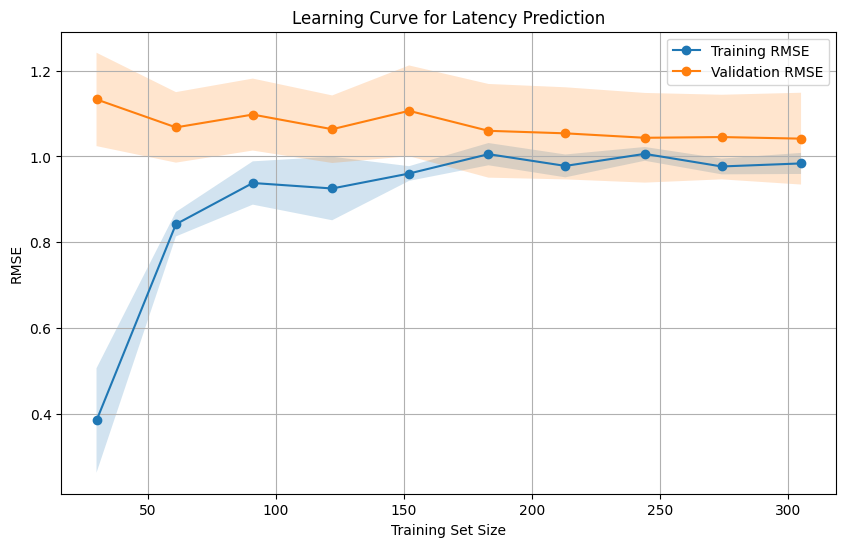

In [26]:

train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training RMSE")
plt.plot(train_sizes, test_mean, 'o-', label="Validation RMSE")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.title("Learning Curve for Latency Prediction")
plt.legend()
plt.grid(True)
plt.show()


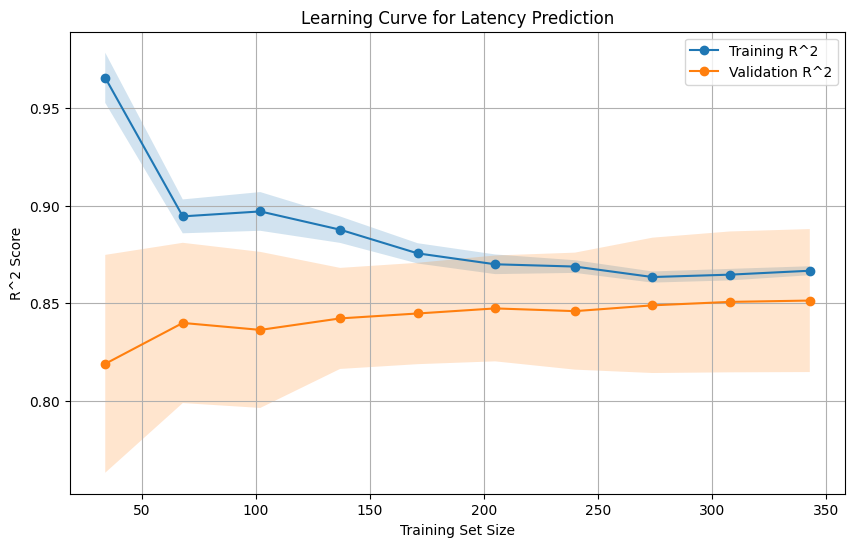

In [18]:

train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=kf, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training R^2")
plt.plot(train_sizes, test_mean, 'o-', label="Validation R^2")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel("Training Set Size")
plt.ylabel("R^2 Score")
plt.title("Learning Curve for Latency Prediction")
plt.legend()
plt.grid(True)
plt.show()

## Prediction Example

In [55]:

sample = pd.DataFrame([{
    'users':50,
    'cpu_cores': 0.25,
    'available_memory': 512,
    'endpoint_code': 2, #where /chatclient is 1, /owners is 2, /vets is 3
    'deployment_code': 1 #where ecs is 1, ec2 is 2
}])

for col in X.columns:
    if col not in sample.columns:
        sample[col] = 0

sample = sample[X.columns]

pipeline.fit(X, y)
predicted_latency_rf = pipeline.predict(sample)[0]

pipeline_xgb.fit(X, y)
predicted_latency_xgb = pipeline_xgb.predict(sample)[0]

pipeline_gbr.fit(X, y)
predicted_latency_gbr = pipeline_gbr.predict(sample)[0]

pipeline_svr.fit(X, y)
predicted_latency_svr = pipeline_svr.predict(sample)[0]

print(f"Predicted latency (RF): {predicted_latency_rf:.4f} seconds")
print(f"Predicted latency (XGB): {predicted_latency_xgb:.4f} seconds")
print(f"Predicted latency (GBR): {predicted_latency_gbr:.4f} seconds")
print(f"Predicted latency (svr): {predicted_latency_svr:.4f} seconds")

Predicted latency (RF): 0.0732 seconds
Predicted latency (XGB): 0.0716 seconds
Predicted latency (GBR): 0.0704 seconds
Predicted latency (svr): 0.1586 seconds


In [41]:
latency_by_group = (
    df.groupby(["users", "deployment", "endpoint"])
    .agg(avg_latency=("latency", "mean"))
    .reset_index()
)

print(latency_by_group)

    users deployment          endpoint  avg_latency
0       5        ec2   customer/owners     0.066587
1       5        ec2  genai/chatclient     3.500262
2       5        ec2          vet/vets     0.078752
3       5        ecs   customer/owners     0.074643
4       5        ecs  genai/chatclient     4.003794
5       5        ecs          vet/vets     0.066120
6      10        ec2   customer/owners     0.072812
7      10        ec2  genai/chatclient     4.980357
8      10        ec2          vet/vets     0.083416
9      10        ecs   customer/owners     0.075729
10     10        ecs  genai/chatclient     4.879761
11     10        ecs          vet/vets     0.083739
12     20        ec2   customer/owners     0.079719
13     20        ec2  genai/chatclient     5.325083
14     20        ec2          vet/vets     0.083101
15     20        ecs   customer/owners     0.072600
16     20        ecs  genai/chatclient     5.037218
17     20        ecs          vet/vets     0.076681
18     50   

In [69]:

# kf = KFold(n_splits=10, shuffle=True, random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='r2')
print("Random Forest Regressor")
print(f"Average RMSE: {-scores.mean():.4f} ± {scores.std():.4f}")
print(f"Mean R^2 Score: {cv_scores.mean():.4f}\n")
# cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='r2')


# Gradient Boosting Regressor
scores_gbr_rmse = cross_val_score(pipeline_gbr, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
scores_gbr_r2 = cross_val_score(pipeline_gbr, X_train, y_train, cv=kf, scoring='r2')

print("Gradient Boosting Regressor")
print(f"Average RMSE: {-scores_gbr_rmse.mean():.4f} ± {scores_gbr_rmse.std():.4f}")
print(f"Mean R^2 Score: {scores_gbr_r2.mean():.4f}\n")

# XGBoost Regressor
scores_xgb_rmse = cross_val_score(pipeline_xgb, X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
scores_xgb_r2 = cross_val_score(pipeline_xgb, X_train, y_train, cv=kf, scoring='r2')

print("XGBoost Regressor")
print(f"Average RMSE: {-scores_xgb_rmse.mean():.4f} ± {scores_xgb_rmse.std():.4f}")
print(f"Mean R^2 Score: {scores_xgb_r2.mean():.4f}\n")



Random Forest Regressor
Average RMSE: 1.0061 ± 0.1524
Mean R^2 Score: 0.8513

Gradient Boosting Regressor
Average RMSE: 1.0039 ± 0.1521
Mean R^2 Score: 0.8522

XGBoost Regressor
Average RMSE: 1.0030 ± 0.1525
Mean R^2 Score: 0.8525



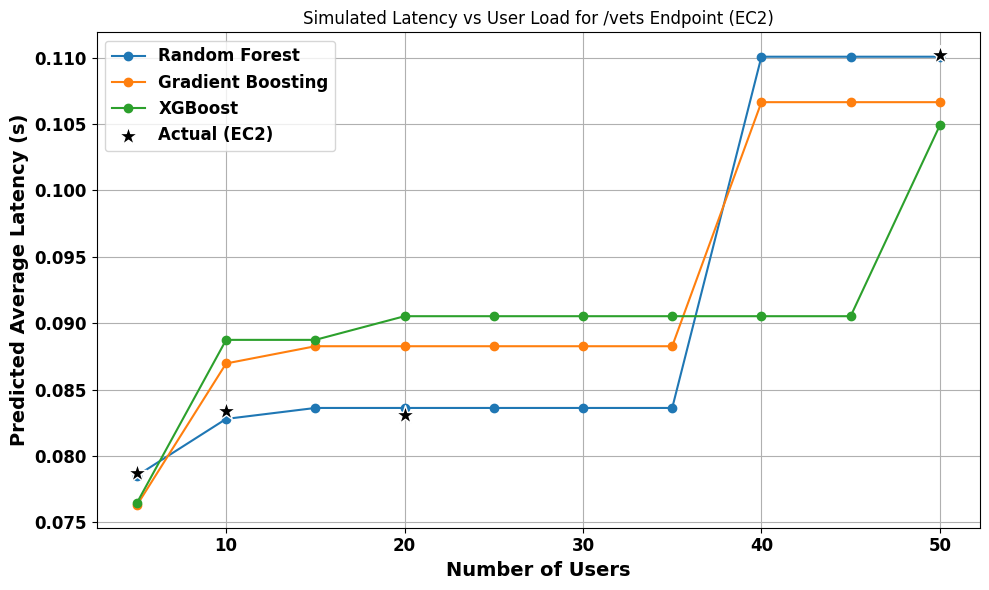

In [70]:
# Get the actual latency for the /vets endpoint and ec2 deployment
actual_latency = (
    df[(df["endpoint"] == "vet/vets") & (df["deployment"] == "ec2")]
    .groupby("users")
    .agg(avg_latency=("latency", "mean"))
    .reset_index()
)

# Define fixed values
cpu_cores = 0.25
available_memory = 512 
deployment_code = 2 #where ecs is 1, ec2 is 2

# Simulate user load from 5 to 100 in increments of 5
user_range = list(range(5, 55, 5))

# endpoint_map = {1: "/chatclient", 2: "/owners", 3: "/vets"}
endpoint_map = {3: "/vets"}

# Store all model predictions for plotting
model_predictions = {
    "Random Forest": pipeline,
    "Gradient Boosting": pipeline_gbr,
    "XGBoost": pipeline_xgb
}

plt.figure(figsize=(10, 6))

for model_name, model in model_predictions.items():
    for endpoint_code, endpoint_name in endpoint_map.items():
        latencies = []
        for users in user_range:
            sample = pd.DataFrame([{
                'users': users,
                'cpu_cores': cpu_cores,
                'available_memory': available_memory,
                'endpoint_code': endpoint_code,
                'deployment_code': deployment_code
            }])
            for col in X.columns:
                if col not in sample.columns:
                    sample[col] = 0
            sample = sample[X.columns]

            latency = model.predict(sample)[0]
            latencies.append(latency)

        plt.plot(user_range, latencies, marker='o', label=f"{model_name}")

# Overlay actual latency points for EC2 deployment
actual_ec2 = actual_latency  # Already filtered for EC2 above

plt.scatter(
    actual_ec2["users"],
    actual_ec2["avg_latency"],
    color='black',
    label="Actual (EC2)",
    zorder=5,
    marker='*',      
    s=200,        
    edgecolor='white', 
    linewidths=1
)


plt.title("Simulated Latency vs User Load for /vets Endpoint (EC2)")
plt.xlabel("Number of Users", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Average Latency (s)", fontsize=14, fontweight='bold')
plt.legend()

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
legend = plt.legend(title_fontsize=12, fontsize=12)
legend.get_title().set_fontweight('bold') 
for text in legend.get_texts():
    text.set_fontweight('bold')

plt.grid(True)
plt.tight_layout()
plt.show()


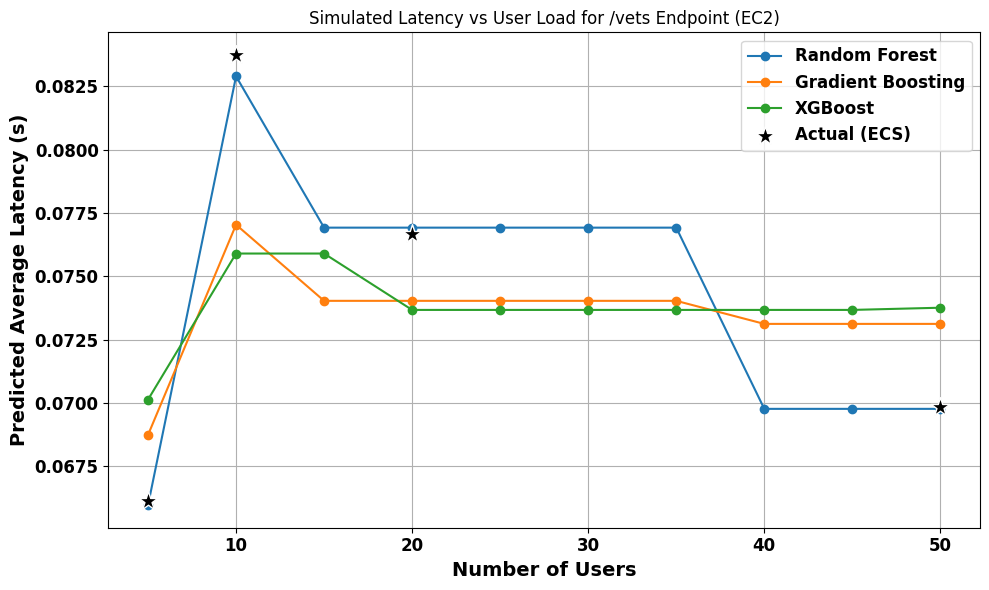

In [68]:
# Get the actual latency for the /vets endpoint and ec2 deployment
actual_latency = (
    df[(df["endpoint"] == "vet/vets") & (df["deployment"] == "ecs")]
    .groupby("users")
    .agg(avg_latency=("latency", "mean"))
    .reset_index()
)

# Define fixed values
cpu_cores = 0.25
available_memory = 512 
deployment_code = 1 #where ecs is 1, ec2 is 2

# Simulate user load from 5 to 100 in increments of 2
user_range = list(range(5, 55, 5))

# endpoint_map = {1: "/chatclient", 2: "/owners", 3: "/vets"}
endpoint_map = {3: "/vets"}

# Store all model predictions for plotting
model_predictions = {
    "Random Forest": pipeline,
    "Gradient Boosting": pipeline_gbr,
    "XGBoost": pipeline_xgb
    # ,
    # "Support Vector": pipeline_svr
}

plt.figure(figsize=(10, 6))

for model_name, model in model_predictions.items():
    for endpoint_code, endpoint_name in endpoint_map.items():
        latencies = []
        for users in user_range:
            sample = pd.DataFrame([{
                'users': users,
                'cpu_cores': cpu_cores,
                'available_memory': available_memory,
                'endpoint_code': endpoint_code,
                'deployment_code': deployment_code
            }])
            for col in X.columns:
                if col not in sample.columns:
                    sample[col] = 0
            sample = sample[X.columns]

            latency = model.predict(sample)[0]
            latencies.append(latency)

        plt.plot(user_range, latencies, marker='o', label=f"{model_name}")

# Overlay actual latency points for EC2 deployment
actual_ec2 = actual_latency  # Already filtered for EC2 above
plt.scatter(
    actual_ec2["users"],
    actual_ec2["avg_latency"],
    color='black',
    label="Actual (ECS)",
    zorder=5,
    marker='*',      
    s=200,        
    edgecolor='white', 
    linewidths=1
)

plt.title("Simulated Latency vs User Load for /vets Endpoint (EC2)")
plt.xlabel("Number of Users", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Average Latency (s)", fontsize=14, fontweight='bold')
plt.legend()

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
legend = plt.legend(title_fontsize=12, fontsize=12)
legend.get_title().set_fontweight('bold') 
for text in legend.get_texts():
    text.set_fontweight('bold')

plt.grid(True)
plt.tight_layout()
plt.show()